In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 4118
Neutral : 35704
Negative : 326


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  862


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Nature/Parks'][df1['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Must go! Views are spectacular']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['must', 'go', 'views', 'are', 'spectacular']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['must', 'go', 'views', 'are', 'spectacular']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['go', 'view', 'spectacular']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('go', 1), ('spectacular', 1), ('view', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.285*"view" + 0.063*"nature" + 0.061*"walk" + 0.044*"adventure" + '
  '0.038*"baboon" + 0.031*"make" + 0.022*"poorly" + 0.022*"manage" + '
  '0.022*"past" + 0.022*"way"'),
 (1,
  '0.221*"tour" + 0.080*"recommend" + 0.076*"highly" + 0.039*"guide" + '
  '0.028*"travel" + 0.028*"top" + 0.026*"operator" + 0.023*"go" + '
  '0.022*"region" + 0.022*"company"'),
 (2,
  '0.157*"spectacular" + 0.134*"wildlife" + 0.090*"unique" + 0.034*"spot" + '
  '0.030*"extraordinary" + 0.029*"ride" + 0.026*"natural" + 0.023*"continent" '
  '+ 0.023*"vista" + 0.023*"safe"'),
 (3,
  '0.167*"stunning" + 0.166*"scenery" + 0.084*"people" + 0.050*"tribe" + '
  '0.037*"world" + 0.033*"simply" + 0.032*"simien" + 0.027*"authentic" + '
  '0.018*"roof" + 0.016*"earth"'),
 (4,
  '0.317*"unforgettable" + 0.064*"well" + 0.050*"week" + 0.038*"organize" + '
  '0.021*"culture" + 0.019*"budget" + 0.019*"find" + 0.015*"price" + '
  '0.014*"eyosi" + 0.013*"monkey"'),
 (5,
  '0.387*"experience" + 0.117*"incredible" + 0.0

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.29695148410971

Coherence Score:  0.6111291452681651


In [17]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('trip', 0.33689839572192515),
   ('day', 0.21390374331550802),
   ('simien', 0.0427807486631016),
   ('world', 0.026737967914438502),
   ('service', 0.0213903743315508),
   ('real', 0.0213903743315508),
   ('find', 0.016042780748663103),
   ('adventure', 0.016042780748663103),
   ('climb', 0.0106951871657754),
   ('drive', 0.0106951871657754)]),
 (1,
  [('guide', 0.34375),
   ('area', 0.05),
   ('trip', 0.04375),
   ('travel', 0.04375),
   ('monkey', 0.0375),
   ('southern', 0.0375),
   ('region', 0.025),
   ('track', 0.025),
   ('wild', 0.025),
   ('tour', 0.01875)]),
 (2,
  [('view', 0.2562814070351759),
   ('stunning', 0.21608040201005024),
   ('day', 0.08542713567839195),
   ('wildlife', 0.08040201005025126),
   ('time', 0.04020100502512563),
   ('lot', 0.020100502512562814),
   ('price', 0.020100502512562814),
   ('experiance', 0.01507537688442211),
   ('beware', 0.01507537688442211),
   ('bewket', 0.010050251256281407)]),
 (3,
  [('unforgettable', 0.2754491017964072),
  

2
3
4
5
6
7
8
9
10


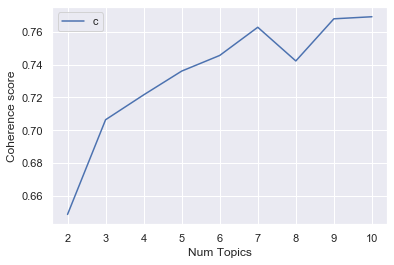

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6487
Num Topics = 3  has Coherence Value of 0.7064
Num Topics = 4  has Coherence Value of 0.7216
Num Topics = 5  has Coherence Value of 0.7361
Num Topics = 6  has Coherence Value of 0.7456
Num Topics = 7  has Coherence Value of 0.7628
Num Topics = 8  has Coherence Value of 0.7423
Num Topics = 9  has Coherence Value of 0.768
Num Topics = 10  has Coherence Value of 0.7692


In [22]:
optimal_model = model_list[8] # Number of Topics = 10

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.337*"trip" + 0.214*"day" + 0.043*"simien" + 0.027*"world" + '
  '0.021*"service" + 0.021*"real" + 0.016*"find" + 0.016*"adventure" + '
  '0.011*"climb" + 0.011*"drive"'),
 (1,
  '0.344*"guide" + 0.050*"area" + 0.044*"trip" + 0.044*"travel" + '
  '0.037*"monkey" + 0.037*"southern" + 0.025*"region" + 0.025*"track" + '
  '0.025*"wild" + 0.019*"tour"'),
 (2,
  '0.256*"view" + 0.216*"stunning" + 0.085*"day" + 0.080*"wildlife" + '
  '0.040*"time" + 0.020*"lot" + 0.020*"price" + 0.015*"experiance" + '
  '0.015*"beware" + 0.010*"bewket"'),
 (3,
  '0.275*"unforgettable" + 0.174*"experience" + 0.048*"operator" + '
  '0.042*"local" + 0.036*"adventure" + 0.036*"hike" + 0.024*"gismu" + '
  '0.018*"country" + 0.018*"remote" + 0.012*"camping"'),
 (4,
  '0.430*"experience" + 0.081*"tribe" + 0.076*"baboon" + 0.041*"driver" + '
  '0.041*"authentic" + 0.023*"extraordinary" + 0.023*"week" + 0.017*"sight" + '
  '0.017*"bale" + 0.012*"challenge"'),
 (5,
  '0.466*"tour" + 0.121*"trek" + 0.046*"worl

In [27]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.089718  0.082634       1        1  10.053274
2     -0.156837 -0.272229       2        1  10.043449
6     -0.158371 -0.118200       3        1  10.038755
1     -0.145022 -0.023278       4        1  10.028886
5     -0.114035  0.273769       5        1  10.005686
0     -0.137030 -0.179862       6        1  10.004753
3      0.283759 -0.031666       7        1   9.971732
9     -0.116815  0.291395       8        1   9.965843
4      0.326142 -0.045638       9        1   9.949238
8      0.307927  0.023074      10        1   9.938384, topic_info=    Category        Freq           Term       Total  loglift  logprob
5    Default  159.000000     experience  159.000000  30.0000  30.0000
3    Default   92.000000           tour   92.000000  29.0000  29.0000
11   Default   72.000000           trip   72.000000  28.0000  28.0000
17   Default   75.000000          guide   75.000000  27.0000  27.0000
22   Default   52.000000  unforgettable   52.000000  26.0000  26.0000
23   Default   51.000000        scenery   51.000000  25.0000  25.0000
2    Default   48.000000           view   48.000000  24.0000  24.0000
18   Default   46.000000     incredible   46.000000  23.0000  23.0000
28   Default   56.000000            day   56.000000  22.0000  22.0000
35   Default   41.000000       stunning   41.000000  21.0000  21.0000
1    Default   30.000000    spectacular   30.000000  20.0000  20.0000
9    Default   28.000000      recommend   28.000000  19.0000  19.0000
7    Default   26.000000         highly   26.000000  18.0000  18.0000
4    Default   38.000000           trek   38.000000  17.0000  17.0000
33   Default   20.000000      landscape   20.000000  16.0000  16.0000
333  Default   17.000000         people   17.000000  15.0000  15.0000
100  Default   23.000000       wildlife   23.000000  14.0000  14.0000
6    Default   16.000000         unique   16.000000  13.0000  13.0000
101  Default   15.000000          tribe   15.000000  12.0000  12.0000
41   Default   14.000000         hiking   14.000000  11.0000  11.0000
36   Default   14.000000         baboon   14.000000  10.0000  10.0000
105  Default   19.000000           time   19.000000   9.0000   9.0000
124  Default   12.000000            top   12.000000   8.0000   8.0000
116  Default   15.000000          night   15.000000   7.0000   7.0000
53   Default   15.000000          worth   15.000000   6.0000   6.0000
8    Default   11.000000           make   11.000000   5.0000   5.0000
134  Default   11.000000         animal   11.000000   4.0000   4.0000
84   Default   10.000000           walk   10.000000   3.0000   3.0000
120  Default   10.000000         nature   10.000000   2.0000   2.0000
10   Default    9.000000           life    9.000000   1.0000   1.0000
..       ...         ...            ...         ...      ...      ...
77   Topic10    4.966577          earth    4.966577   2.3088  -3.6376
62   Topic10    1.241644           live    1.241644   2.3088  -5.0239
47   Topic10    6.208221        company    6.208221   2.3088  -3.4144
41   Topic10   14.899730         hiking   14.899730   2.3088  -2.5390
34   Topic10    3.724933           rare    3.724933   2.3088  -3.9253
8    Topic10   11.174798           make   11.174798   2.3088  -2.8267
244  Topic10    1.241644    responsible    1.241644   2.3088  -5.0239
231  Topic10    1.241644          match    1.241644   2.3088  -5.0239
254  Topic10    1.241644          crowd    1.241644   2.3088  -5.0239
339  Topic10    1.241644           open    1.241644   2.3088  -5.0239
498  Topic10    1.241644       spirited    1.241644   2.3088  -5.0239
491  Topic10    1.241644           mont    1.241644   2.3088  -5.0239
485  Topic10    2.483288       reliable    2.483288   2.3088  -4.3307
459  Topic10    1.241644        develop    1.241644   2.3088  -5.0239
435  Topic10    1.241644        diverse    1.241644   2.3088  -5.0239
333  Topic10   17.3

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1154,"view, stunning, day, wildlife, time, lot, pric...",Must go! Views are spectacular
1,1,0.0,0.1000,"trip, day, simien, world, service, real, find,...",Awe inspiring
2,2,5.0,0.1282,"tour, trek, world, absolutely, night, worth, t...",Simien mountains trekking and tours :)
3,3,3.0,0.1068,"unforgettable, experience, operator, local, ad...",Great experience.
4,4,0.0,0.1000,"trip, day, simien, world, service, real, find,...",Wonderful trek in the Simien Mountains Nationa...
5,5,0.0,0.1000,"trip, day, simien, world, service, real, find,...",Amazing
6,6,6.0,0.1154,"recommend, highly, unique, time, animal, organ...",Omo Valley - It is an unique experience
7,7,5.0,0.1155,"tour, trek, world, absolutely, night, worth, t...",Amazing tour with Mieraf
8,8,6.0,0.1296,"recommend, highly, unique, time, animal, organ...",Excellent Guide made for a Wonderful Experienc...
9,9,0.0,0.1154,"trip, day, simien, world, service, real, find,...",Once in my life Good guide and nice trip


In [24]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    463
2.0    104
4.0     84
7.0     84
3.0     83
6.0     77
5.0     76
1.0     72
9.0     65
8.0     58
Name: Dominant_Topic, dtype: int64

In [25]:
df_dominant_topic.to_csv('ethiopia_432.csv', index = False)

In [42]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Topicless/Unidentifiable - 463
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Tour Guide - 72
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Visual (Wildlife, Scenery, etc.) - 104
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Trekking/Hiking Experience - 83
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Visual (Wildlife, Scenery, etc.) - 84
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Trekking/Hiking Experience - 76
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Tour Guide - 77
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Visual (Wildlife, Scenery, etc.) - 84
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Trekking/Hiking Experience - 58
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 9]['Text'].values # Visual (Wildlife, Scenery, etc.) - 65

In [32]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # General Appreciation - 474
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Visual (Wildlife, Scenery, etc.) - 81
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Visual (Wildlife, Scenery, etc.) - 87
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Trekking/Hiking Experience - 87
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Trekking/Hiking Experience - 76
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # General Appreciation - 60
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Tour Guide - 67
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Trekking/Hiking Experience - 81
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Visual (Wildlife, Scenery, etc.) - 84
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 9]['Text'].values # Visual (Wildlife, Scenery, etc.) - 69

In [46]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1488,"trip, day, simien, world, service, real, find,...",Beautiful park but unsuited for a day trip
1,1.0,0.1349,"guide, area, trip, travel, monkey, southern, r...",Close encounters with Walia Ibex and Gelada ba...
2,2.0,0.1509,"view, stunning, day, wildlife, time, lot, pric...",Amazing views but beware of fleas
3,3.0,0.1296,"unforgettable, experience, operator, local, ad...","Nega Setagachew - expert local knowledge, fant..."
4,4.0,0.1342,"experience, tribe, baboon, driver, authentic, ...",A True Wildrrness Experience Ethiopian Style
5,5.0,0.1420,"tour, trek, world, absolutely, night, worth, t...",The most adventureous place in the world and w...
6,6.0,0.1607,"recommend, highly, unique, time, animal, organ...",Explore Abyssinia Travel - highly highly highl...
7,7.0,0.1509,"scenery, incredible, worth, life, trekking, vi...",Incredible scenery and culture
8,8.0,0.1346,"experience, people, hiking, night, make, compa...",Hiking in the Simien Mountains made easy
9,9.0,0.1409,"spectacular, landscape, trek, top, nature, wal...","Big city , main tourist center because of the ..."


In [47]:
sent_topics_sorteddf_mallet['Text'].values

array(['Beautiful park but unsuited for a day trip ',
       'Close encounters with Walia Ibex and Gelada baboons in a spectacular setting',
       'Amazing views but beware of fleas',
       'Nega Setagachew - expert local knowledge, fantastic trek co-ordinator',
       'A True Wildrrness Experience Ethiopian Style',
       'The most adventureous place in the world and where travelers sense wonder!!',
       'Explore Abyssinia Travel - highly highly highly recommend!!!!!',
       'Incredible scenery and culture',
       'Hiking in the Simien Mountains made easy',
       'Big city , main tourist center because of the area '],
      dtype=object)

In [48]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics